In [1]:
import plotly.graph_objects as go
import networkx as nx
import matplotlib.pyplot as plt

In [2]:
import pandas as pd
sheep_age_csv = './sheep_data/sheep_age.csv'
df_sheep_age = pd.read_csv(sheep_age_csv)
sheep_edges_csv = './sheep_data/sheep_edges.csv'
df_sheep_edges = pd.read_csv(sheep_edges_csv)

### Data Exploration

In [3]:
df_sheep_age.head()

,id,age
0,1,8
1,2,8
2,3,4
3,4,7
4,5,8


In [4]:
df_sheep_edges.head()

,source,target,weight
0,1,2,1
1,1,3,1
2,1,4,1
3,1,5,1
4,1,6,1


In [5]:
df_sheep_edges.describe()

,source,target,weight
count,250.000000,250.000000,250.000000
mean,13.092000,16.716000,2.632000
std,7.952894,7.501763,2.184414
min,1.000000,2.000000,1.000000
25%,7.000000,11.000000,1.000000
50%,13.000000,18.000000,2.000000
75%,19.000000,23.000000,3.000000
max,28.000000,28.000000,12.000000


## Building  a graph on given data
We build the graph given the sheep dominance over each other. Drawing graph as the data provide to see how it looks

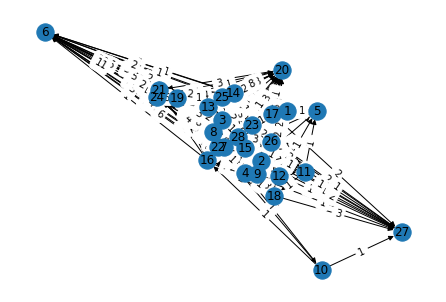

In [6]:
G = nx.DiGraph()
sheeps = df_sheep_age.to_dict(orient='records')
for sheep in sheeps:
    G.add_node(sheep['age'], size= sheep['age']*10 )

# adding edges
sheep_edges = df_sheep_edges.to_dict(orient='records')
for sheep_edge in sheep_edges:
    G.add_edge(sheep_edge['source'], sheep_edge['target'], weight=sheep_edge['weight'])

pos = nx.spring_layout(G)  # positions for all nodes

nx.draw(G, pos, with_labels=True)
edge_weight = nx.get_edge_attributes(G,'weight')
nx.draw_networkx_edge_labels(G, pos, edge_labels = edge_weight)

plt.axis("off")
plt.show()

## Improving on Graph
Since the graph has too many nodes and edges it was hard to make sense out of it using graph layout. We decided to augment data grouping sheep by their age and sum their weights to understand if age is a factor in dominance.

In [7]:
# Merging data for age
m1 = pd.merge(df_sheep_edges, df_sheep_age,how='inner', left_on='source', right_on='id', suffixes=('_left','_source'))

In [8]:

m2 = pd.merge(m1, df_sheep_age,how='inner', left_on='target', right_on='id', suffixes=('_source','_target'))

In [9]:
df_age = m2[['age_source', 'age_target', 'weight']]

In [10]:
df_age.head()

,age_source,age_target,weight
0,8,8,1
1,4,8,1
2,7,8,1
3,4,8,2
4,9,8,4


## Grouping by Age and summing up on weights

In [11]:
df_age_grouped = df_age.groupby(['age_source','age_target'],as_index=False).sum()
df_age_grouped.head()

,age_source,age_target,weight
0,1,1,34
1,1,3,61
2,1,4,31
3,1,6,1
4,1,7,31


## Graph Creation
Create a directed graph with each node representing age. Edge and their weights represent dominance between each nodes. Size of the node reflects the dominance of age. Larger the size, more dominant the age is.

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


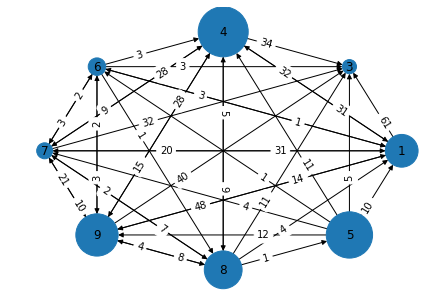

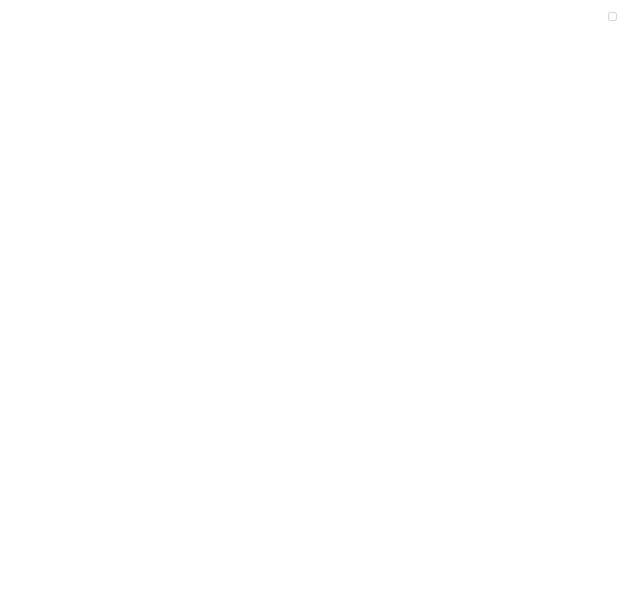

In [12]:
# Creates a directed Graph
G = nx.DiGraph()

# add source and target nodes along with edges
# Removes cyclic edges
for age in df_age_grouped.to_dict(orient='records'):
    if age['age_source'] != age['age_target']:
        G.add_edge(age['age_source'], age['age_target'], weight=age['weight'])

        

# Set the layout
pos = nx.circular_layout(G)  # positions for all nodes

# Calculate degree to size nodes
# Node that has the most out going weights will have more value
d_out = dict(G.out_degree(weight='weight'))
d_in = dict(G.in_degree(weight='weight'))
d_net={}
for k,v in d_out.items():
    d_net[k] = d_out[k] - d_in[k]

# Normalize the degree     
m = max(list(d_net.values()))
d_norm = [float(i)/m for i in d_net.values()]

# Draw node with sizes as per the degree of node
nx.draw(G, pos, with_labels=True, node_size=[v*2500 if v>0 else 200 for v in d_norm], alpha=1)
#         , connectionstyle='arc3, rad = 0.1')

# Draw graph with the weighted directional edges
nx.draw_networkx_edge_labels(G,
                             pos,
                             edge_labels={(u, v): d for u, v, d in G.edges(data="weight")},
                             label_pos=.66)
plt.figure(3,figsize=(11,11)) 
plt.legend()
plt.axis("off")
plt.show()